In [19]:
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
# Load data

train = pd.read_csv(r'train.csv')
test = pd.read_csv(r'test.csv')

In [3]:
# Combine comments for processing

train_comments = train['comment_text']
test_comments = train['comment_text']
allComments = pd.concat([train_comments, test_comments])

In [4]:
# Vectorize words

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000
)

word_vectorizer.fit(allComments)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
# Vectorized characters

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=10000
)

char_vectorizer.fit(allComments)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(2, 6), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [20]:
# Transform fitted data
train_word_features = word_vectorizer.transform(train_comments)
test_word_features = word_vectorizer.transform(test_comments)

train_char_features = char_vectorizer.transform(train_comments)
test_char_features = char_vectorizer.transform(test_comments)

In [21]:
# Combine both word_vectorized and char_vectorized data

train_features = hstack([train_word_features, train_char_features])
test_features = hstack([test_char_features, test_char_features])

In [6]:
train_target = train.toxic

In [7]:
# Method 1: Using cross_val_score 

# cross_val_score is a helper function on the estimator and the dataset 
# (where cv will output estimate scores)

def cvs(classifier, trainingSet, testingSet, split=3):
    cv = cross_val_score(classifier, trainingSet, testingSet, cv=split, scoring='roc_auc')
    
    m = np.mean(cv)
    return cv, m

In [22]:
cvs(LogisticRegression(random_state=42), train_features, train_target)

(array([0.97760002, 0.97531257, 0.97703697]), 0.9766498517590015)

In [10]:
cvs(LogisticRegression(random_state=42), train_word_features, train_target)

(array([0.96935283, 0.96679725, 0.96782919]), 0.9679930896083148)

In [8]:
# Method 2: Using Cross Validate 

# cross_validate allows specifying multiple metrics for evaluation
# and returns a dict containing the training scores, fit-times, 
# and score-times in addition to test score

def cv(classifier, trainingSet, testingSet, split=3):
    cv2 = cross_validate(classifier, train_word_features, train_target, cv=3, scoring='roc_auc')

    m = np.mean(cv2['test_score'])
#     print(cv2)

    return cv2['test_score'], m



In [11]:
cv(LogisticRegression(random_state=42), train_word_features, train_target)

(array([0.96935283, 0.96679725, 0.96782919]), 0.9679930896083148)

In [16]:
# Method 3: Using standard train_test_split

def tts(classifier, trainingSet, testingSet, size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(trainingSet, testingSet, test_size=0.33, random_state=42)
#     X_train, X_test, y_train, y_test = train_test_split(train_word_features, train_target, test_size=0.33, random_state=42)

    clf = classifier
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Accuracy
    acc = metrics.accuracy_score(y_test, y_pred)
    
    # Return probability estimates, where a matrix of (N,2) is returned.
    # The first value is the probability of toxic = 0, second is toxic = 1. 
    # Their sum will equal 1.

    # We want the 2nd column (toxic = 1)
    y_pred_proba = clf.predict_proba(X_test)[::, 1]

    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    plt.plot(fpr, tpr, label="AUC = {:.2%}".format(auc))
    plt.title('ROC')
    plt.legend()
    plt.show()
    
    return acc
    

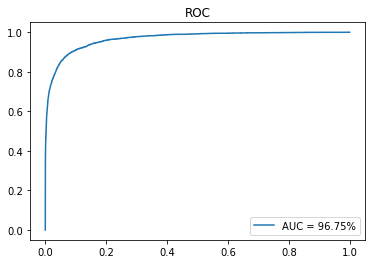

0.9562467954195863

In [50]:
train_target = train.toxic

tts(LogisticRegression(random_state=42), train_word_features, train_target)

In [31]:
# Apply to all classifications

TARGET_COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for target in TARGET_COLUMNS:
    train_target = train[target]
    s = cvs(LogisticRegression(random_state=42), train_features, train_target)
    print('Label: {}\nScore: {:.3%}'.format(target, s[1]))

Label: toxic
Score: 97.665%
Label: severe_toxic
Score: 98.843%
Label: obscene
Score: 98.938%
Label: threat
Score: 98.901%
Label: insult
Score: 98.139%
Label: identity_hate
Score: 98.192%


In [51]:
from sklearn.svm import SVC

In [ ]:
train_target = train.toxic

svm = SVC(kernel='rbf')

tts(svm, train_features, train_target)